In [30]:
import numpy as np
from numpy.linalg import lstsq
from scipy import optimize
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [41]:
l = []

for i in range(1,9):
    for j in range(1,10):
        docString = "groupDtube" + str(i) + "run" + str(j) + ".txt"
        dl = np.loadtxt(docString)
        l.append(dl)

In [42]:
for i in range(0,72):
    ex = l[i]
    ex[:,0] = ex[:,0]-ex[0,0]
    for j in range(0, len(ex)):
        if (ex[j,1] < ex[0,1] -0.075): # this is to cut off any lag in the beginning
            ex = ex[j:,:] #keep everything afterward
            break
    for j in range(int(len(ex)*3/4), len(ex)):
        if(ex[j,1] < 0.17): # we chose this number because our data does not seem acurate past this
            ex = ex[:j,:]
            break
    l[i] = ex

In [36]:
#https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

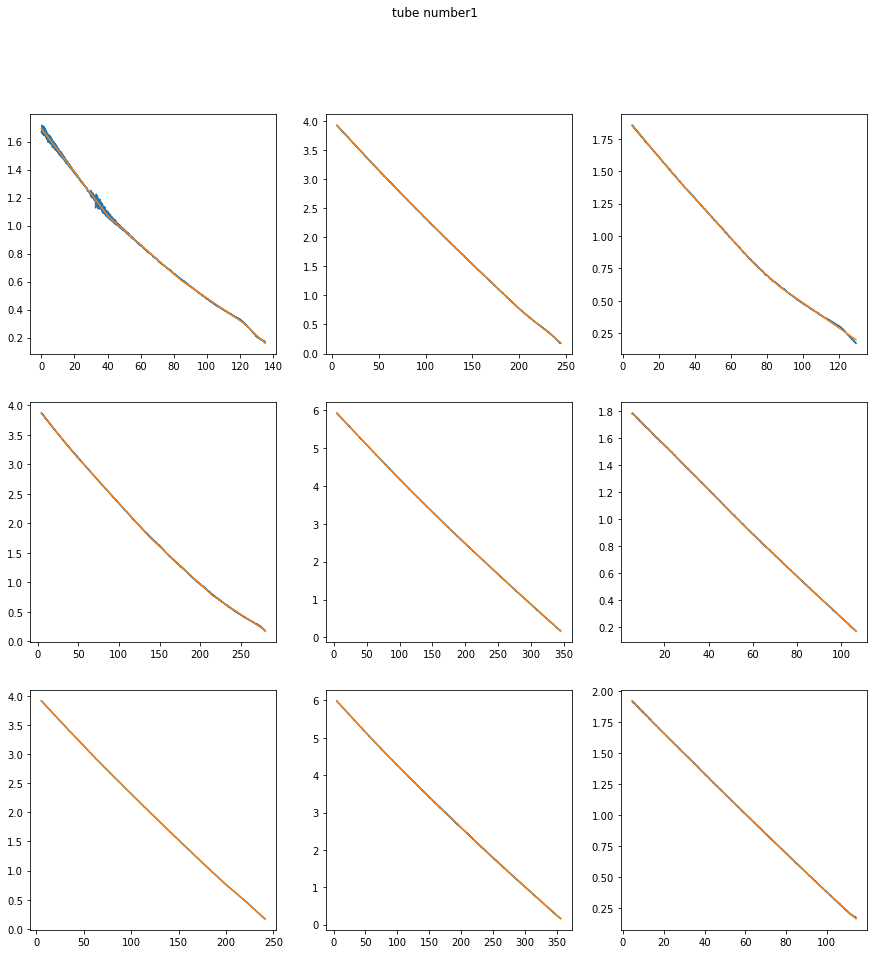

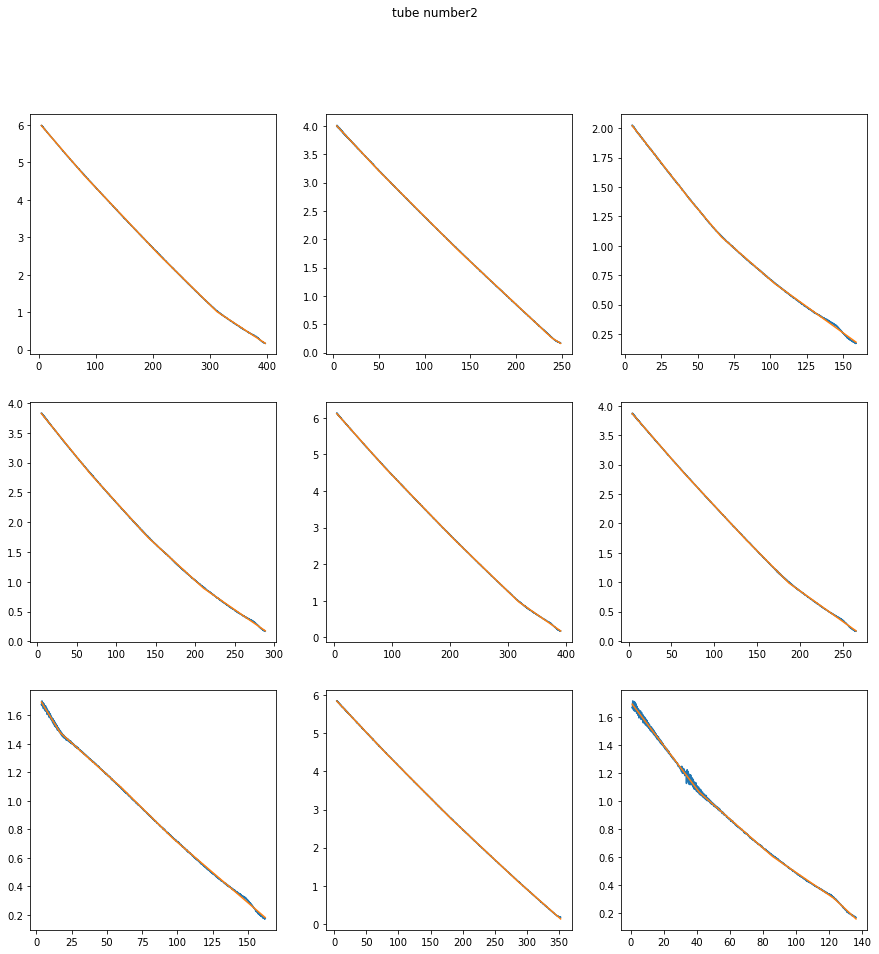

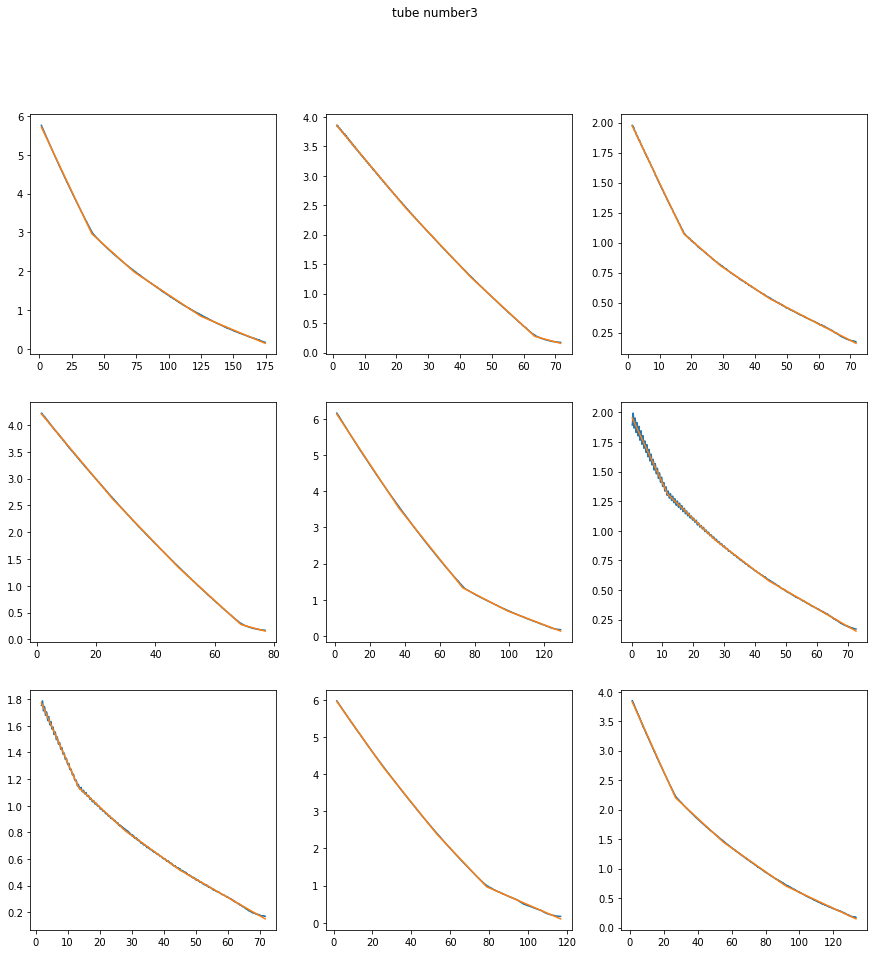

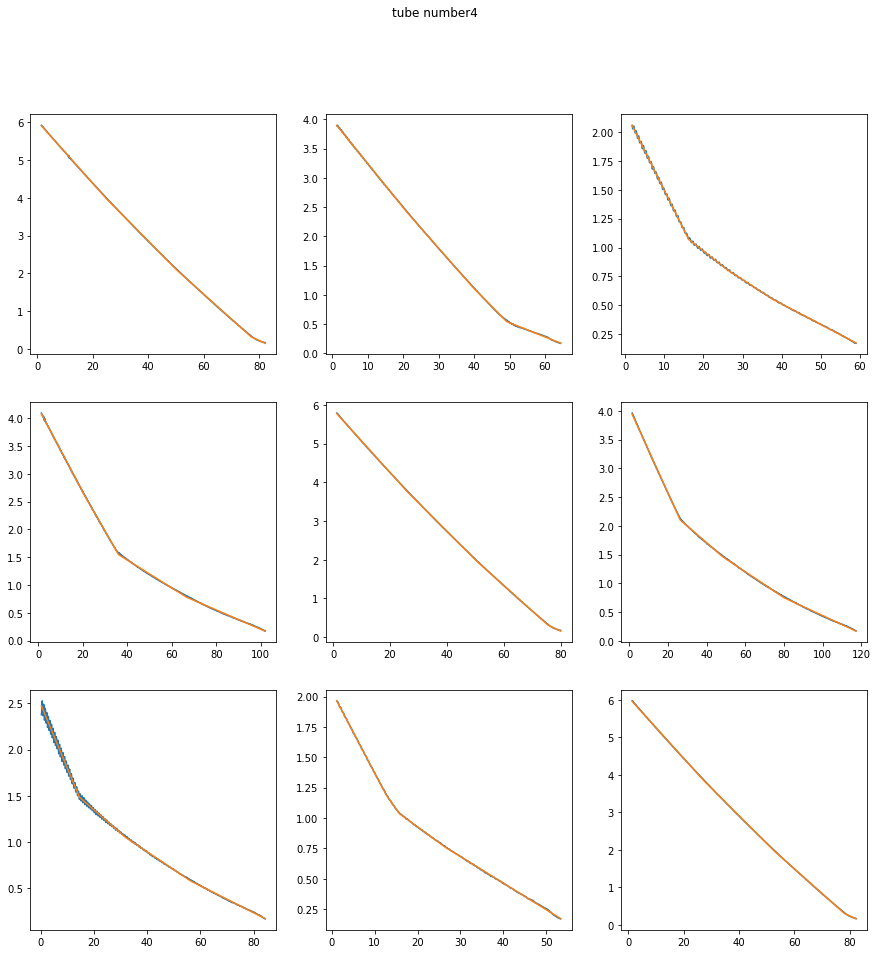

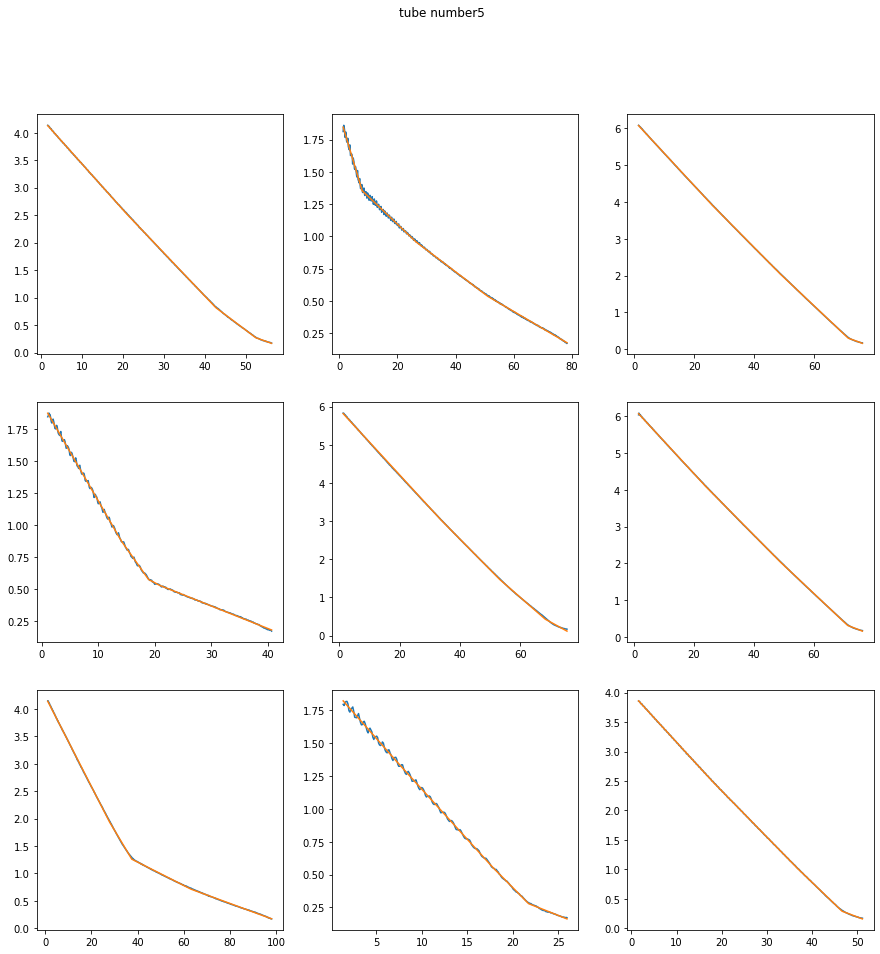

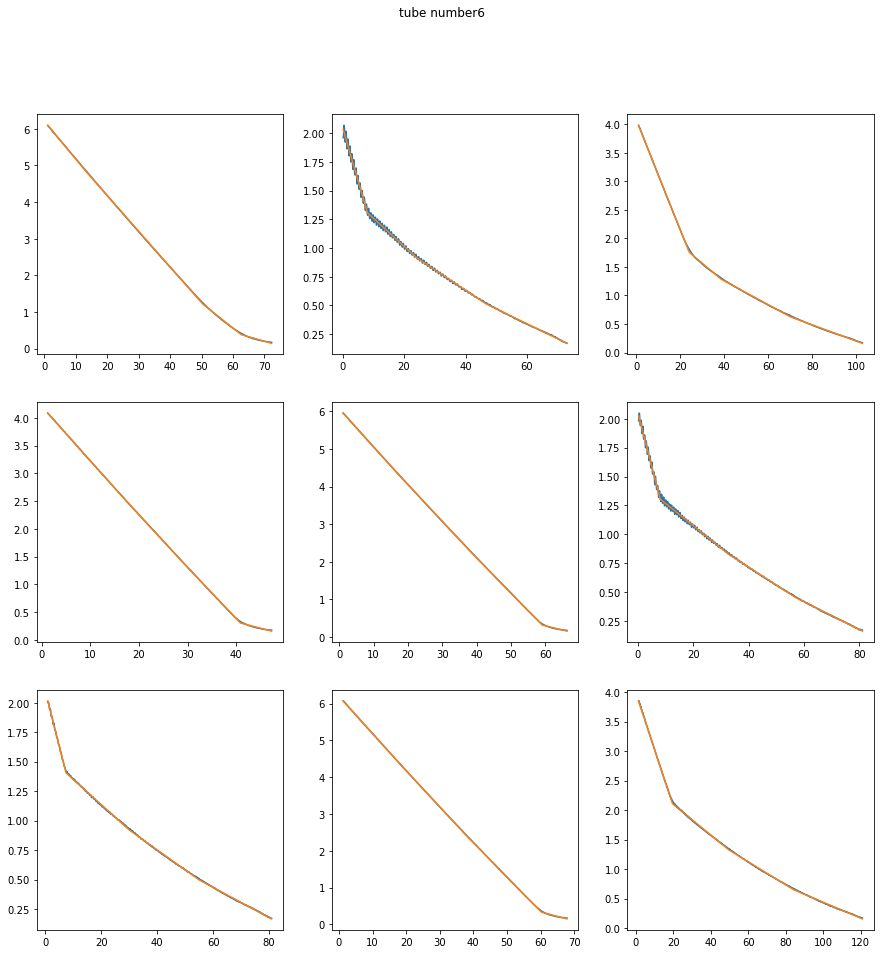

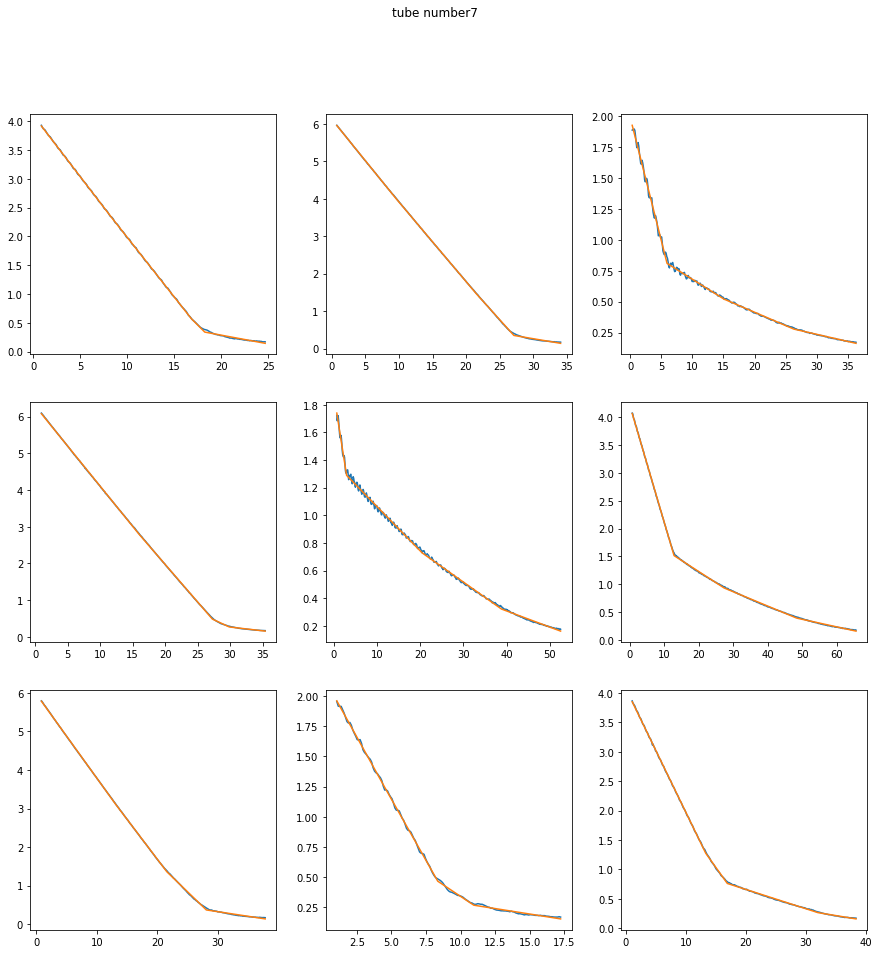

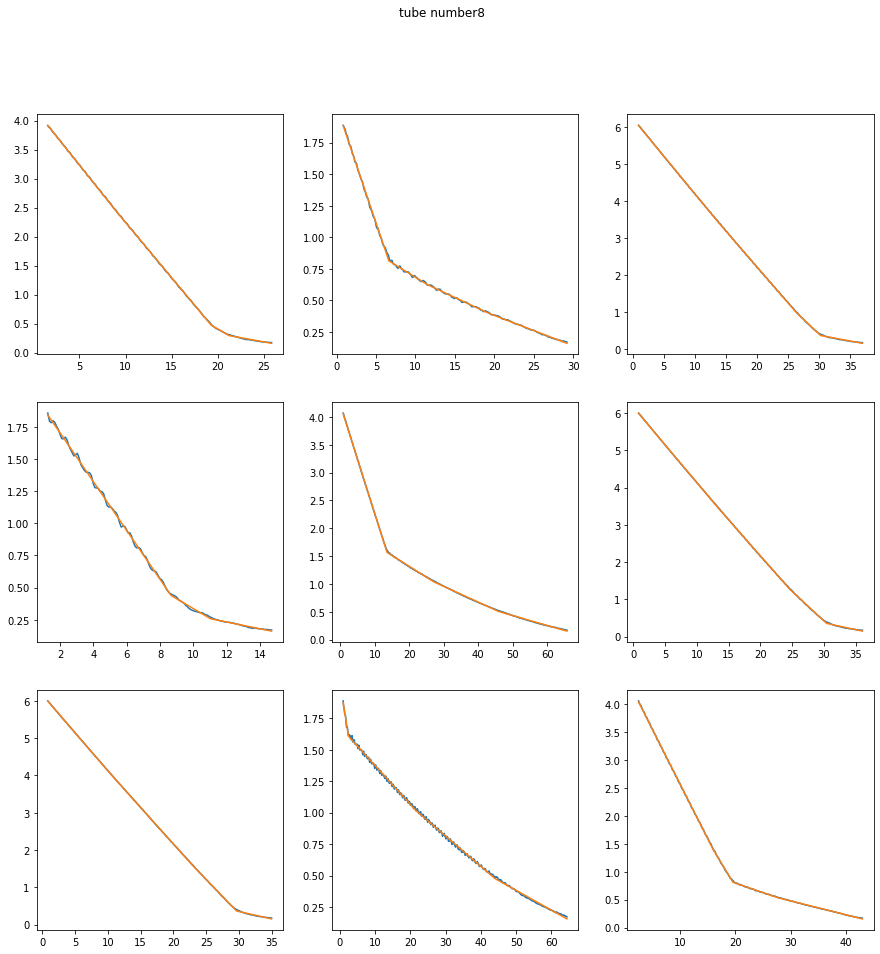

In [50]:
for i in range(0,8):
    fig, ax = plt.subplots(3,3, figsize = (15,15))
    title = "tube number " + str(i+1)
    fig.suptitle(title)
    for j in range(0,3):
        for k in range(0,3):
            ex = l[k+3*j+9*i]
            px, py = segments_fit(ex[:,0], ex[:,1], 4)
            ax[j][k].plot(ex[:,0], ex[:,1])
            ax[j][k].plot(px,py)